In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tqdm import tqdm

from procyon.data.data_utils import DATA_DIR
from procyon.data.inference_utils import (
    create_input_retrieval,
    desc_perturbation,
    get_proteins_from_embedding,
    uniprot_id_to_index,
    UNIPROT_IDS,
)
from procyon.evaluate.framework.utils import move_inputs_to_device
from procyon.model.model_unified import UnifiedProCyon

%matplotlib inline

[2025-02-03 10:16:10,224] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


This notebook recreates the analysis shown in Figure 3g of the manuscript: increasing retrieval ranks of the STING1 protein (UniProt ID: Q86WV6) with descriptions containing increasing levels of evidence for STING1's involvement in neuronal inflammatory stress response.

# Load pre-trained model

In [3]:
# Make sure this line runs, follow instructions in GitHub to set HOME_DIR
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/n/home08/rcalef/sandbox/repos/ProCyon


In [4]:
# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Full"
CKPT_NAME = os.path.expanduser(checkpoint_path)

In [5]:
# Loading the model and transitioning to device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)
model.bfloat16() # Quantize the model to a smaller precision
model.eval()
model.to(device)

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: mouse_ortholog_embeddings_path
updating stal

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.


Processing zero checkpoint '/n/home08/rcalef/storage/Lab/PLM/huggingface_repos/ProCyon-Full/global_step59469'
Detected checkpoint of type zero stage ZeroStageEnum.gradients, world_size: 32
Parsing checkpoint created by deepspeed==0.12.4
Reconstructed fp32 state dict with 322 params 8141117441 elements


UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128263, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
     

In [6]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [7]:
# Load saved embeddings for this model:
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
# Confirm with size:
print(all_protein_embeddings.shape)
assert np.all(np.array(all_protein_ids) == np.sort(np.array(all_protein_ids)))

torch.Size([18174, 2560])


# STING Analysis

In [8]:
sting_idx = uniprot_id_to_index("Q86WV6")

task_def = "You will be shown text descriptions of a biological process in neurons. "\
"Your job is to determine if a protein is involved in the process described. "\
"Involvement is determined by whe ther or not there is evidence from an experiment "\
"directly supporting the annotation of the protein."
print(task_def)

You will be shown text descriptions of a biological process in neurons. Your job is to determine if a protein is involved in the process described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein.


In [9]:
def get_sims_sting_query(
    desc,
    task_def=task_def,
    icl_example_number=1,
):
    # Composition query
    input = create_input_retrieval(
        input_description=desc,
        data_args=data_args,
        task_definition=task_def,
        instruction_source_dataset="go",
        instruction_source_relation="process",
        aaseq_type="protein",
        icl_example_number=icl_example_number,
    )
    input = move_inputs_to_device(input, device=device)

    with torch.no_grad():
        model_out = model(
            inputs=input,
            retrieval=True,
            aaseq_type='protein',
        )

    sims = get_proteins_from_embedding(all_protein_embeddings, model_out, top_k=None).sim_score

    return sims

In [10]:
level1 = "Defensive reaction in neurons during neuroinflammation, "\
"when neurons are chronically challenged by cytokines "\
"and an excess of extracellular glutamate that exacerbates neuronal injury, "\
"the so-called glutamate excitotoxicity."
print(level1)

sims_level1 = get_sims_sting_query(level1)
print(sims_level1)

Defensive reaction in neurons during neuroinflammation, when neurons are chronically challenged by cytokines and an excess of extracellular glutamate that exacerbates neuronal injury, the so-called glutamate excitotoxicity.


16965    0.531250
7074     0.527344
7078     0.527344
7115     0.527344
16243    0.527344
           ...   
9231    -0.220703
16906   -0.240234
5024    -0.308594
9598    -0.390625
645     -0.496094
Name: sim_score, Length: 18174, dtype: float64


In [11]:
stats.percentileofscore(
    sims_level1,
    sims_level1[sting_idx],
)

77.12941564872895

In [12]:
level2 = "Defensive reaction in neurons during neuroinflammation, "\
"when neurons are chronically challenged by cytokines "\
"and an excess of extracellular glutamate that exacerbates neuronal injury, "\
"the so-called glutamate excitotoxicity."\
"The process is characterized by glutamate-induced excitotoxicity activating store-operated calcium entry (SOCE), "\
"which is a pivotal contributor to glutamate excitotoxic cell death during neuroinflammation."
print(level2)

sims_level2 = get_sims_sting_query(level2)
print(sims_level2)

Defensive reaction in neurons during neuroinflammation, when neurons are chronically challenged by cytokines and an excess of extracellular glutamate that exacerbates neuronal injury, the so-called glutamate excitotoxicity.The process is characterized by glutamate-induced excitotoxicity activating store-operated calcium entry (SOCE), which is a pivotal contributor to glutamate excitotoxic cell death during neuroinflammation.
593      0.515625
7074     0.507812
7078     0.507812
7188     0.507812
658      0.503906
           ...   
2708    -0.208008
16906   -0.247070
5024    -0.291016
9598    -0.349609
645     -0.472656
Name: sim_score, Length: 18174, dtype: float64


In [13]:
stats.percentileofscore(
    sims_level2,
    sims_level2[sting_idx],
)

75.3108836799824

In [14]:
level3 = "Defensive reaction in neurons during neuroinflammation, "\
"when neurons are chronically challenged by cytokines "\
"and an excess of extracellular glutamate that exacerbates neuronal injury, "\
"the so-called glutamate excitotoxicity."\
"The process is characterized by glutamate-induced excitotoxicity activating store-operated calcium entry (SOCE), "\
"which is a pivotal contributor to glutamate excitotoxic cell death during neuroinflammation."\
"The activation of SOCE leads to relocation of STIM1 to the cell membrane, "\
"triggering autophagy through mechanisms that remain under investigation, "\
"ultimately amplifying neuronal injury by activating ferroptosis."
print(level3)

sims_level3 = get_sims_sting_query(level3)
print(sims_level3)

Defensive reaction in neurons during neuroinflammation, when neurons are chronically challenged by cytokines and an excess of extracellular glutamate that exacerbates neuronal injury, the so-called glutamate excitotoxicity.The process is characterized by glutamate-induced excitotoxicity activating store-operated calcium entry (SOCE), which is a pivotal contributor to glutamate excitotoxic cell death during neuroinflammation.The activation of SOCE leads to relocation of STIM1 to the cell membrane, triggering autophagy through mechanisms that remain under investigation, ultimately amplifying neuronal injury by activating ferroptosis.
15878    0.542969
15871    0.539062
15877    0.539062
10927    0.535156
15873    0.535156
           ...   
1039    -0.195312
16906   -0.195312
5024    -0.250000
9598    -0.324219
645     -0.376953
Name: sim_score, Length: 18174, dtype: float64


In [15]:
stats.percentileofscore(
    sims_level3,
    sims_level3[sting_idx],
)

99.20215692747882

## Compute scores with perturbations

Calculate STING1 retrieval scores as performed above, but with perturbations of the descriptions (removed words) to estimate confidence intervals of the STING1 retrieval score.

In [16]:
level1_perturbed_scores = desc_perturbation(
    desc=level1,
    query_func=get_sims_sting_query,
    num_perturbations=100,
    perturbation_pct=0.05,
    seed=1234,
)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [17]:
level2_perturbed_scores = desc_perturbation(
    desc=level2,
    query_func=get_sims_sting_query,
    num_perturbations=100,
    perturbation_pct=0.05,
    seed=1234,
)

  0%|                                                                           | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


In [18]:
level3_perturbed_scores = desc_perturbation(
    desc=level3,
    query_func=get_sims_sting_query,
    num_perturbations=100,
    perturbation_pct=0.05,
    seed=1234,
)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [19]:
# Construct df:
df_dict = {"Score":[], "Level":[], "uniprot_id":[], "control":[]}
for i, perturb_dict in enumerate([level1_perturbed_scores, level2_perturbed_scores, level3_perturbed_scores]):
    for sim_scores in perturb_dict.values():
        sting_score = stats.percentileofscore(
            sim_scores,
            sim_scores[sting_idx],
        )
        df_dict["Level"].append(i+1)
        df_dict["Score"].append(sting_score)
        df_dict["uniprot_id"].append("Q86WV6")
        df_dict["control"].append(0)
plot_df = pd.DataFrame(df_dict)
plot_df

,Score,Level,uniprot_id,control
0,66.545615,1,Q86WV6,0
1,88.838451,1,Q86WV6,0
2,66.765709,1,Q86WV6,0
3,85.754374,1,Q86WV6,0
4,47.196545,1,Q86WV6,0
...,...,...,...,...
295,94.871795,3,Q86WV6,0
296,98.002641,3,Q86WV6,0
297,84.384285,3,Q86WV6,0
298,94.131727,3,Q86WV6,0


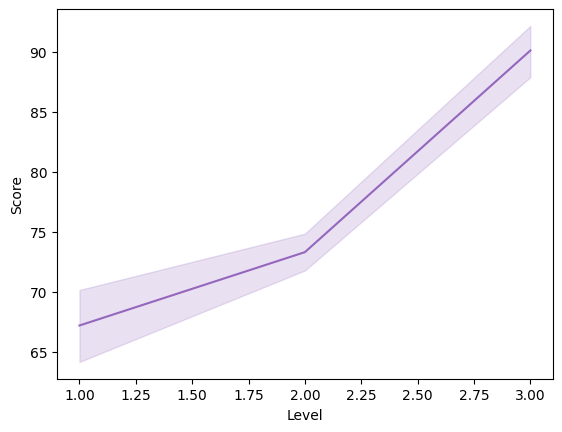

In [20]:
sns.lineplot(data=plot_df, x="Level", y="Score", color="#9467BD")
plt.show()

## Control comparison

Calculate retrieval scores for a set of control proteins that are also expressed in the central nervous system.

In [21]:
# Find reference genes:
genes = pd.read_csv(os.path.join(
    DATA_DIR,
    "experimental_data",
    "sting",
    "gtex_cns_control_genes.csv"
))["UniProtKB/Swiss-Prot ID"]

In [22]:
# 1. Find overlap in our internal proteins:
all_uid = UNIPROT_IDS["protein_id"].tolist()
control_genes = [uid for uid in genes if (uid in all_uid)]

In [23]:
def score_by_uid(uid: str, sims_df: pd.DataFrame) -> float:
    score = stats.percentileofscore(
        sims_df,
        sims_df[uniprot_id_to_index(uid)],
    )
    return score

In [24]:
# Find those that are initially ranked > 0.95 in first query:
threshold = 90.0
control_genes_selected = []
for uid in tqdm(control_genes):
    if score_by_uid(uid, sims_level1) > threshold:
        control_genes_selected.append(uid)
len(control_genes_selected)

100%|████████████████████████████████████████████████████████████| 11249/11249 [00:23<00:00, 481.71it/s]


670

In [25]:
# Create control_df:
for L, sdf in enumerate([sims_level1, sims_level2, sims_level3]):
    for uid in control_genes_selected:
        score = score_by_uid(uid, sdf)
        df_dict["Score"].append(score)
        df_dict["Level"].append(L+1)
        df_dict["control"].append(1)
        df_dict["uniprot_id"].append(uid)

## Plotting

In [26]:
plot_df = pd.DataFrame(df_dict)
plot_df.head()

,Score,Level,uniprot_id,control
0,66.545615,1,Q86WV6,0
1,88.838451,1,Q86WV6,0
2,66.765709,1,Q86WV6,0
3,85.754374,1,Q86WV6,0
4,47.196545,1,Q86WV6,0


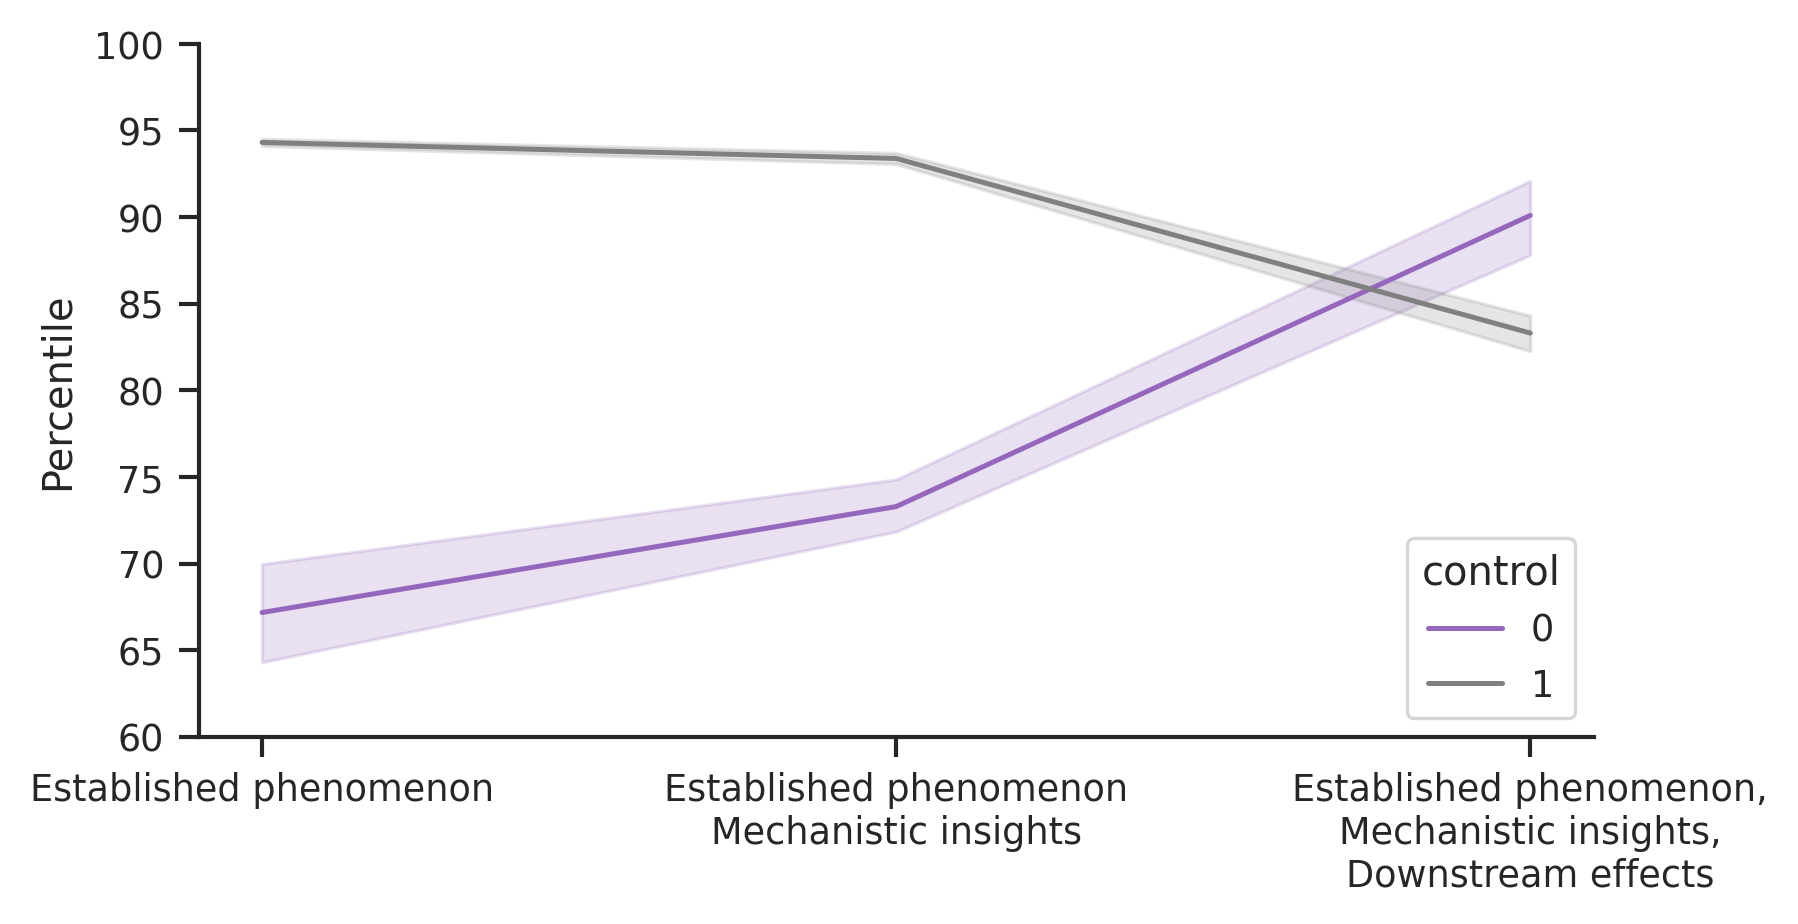

In [27]:
import matplotlib as mpl

plt.figure(figsize=(6,3),dpi=300)
sns.set_theme(context="paper", font_scale=1, style="ticks")
mpl.rcParams['font.family'] = 'sans-serif'

colors = ["#9467BD", "#808080"]
sns.set_palette(sns.color_palette(colors))

sns.lineplot(data=plot_df, x="Level", y="Score", hue="control",
    markers=True, dashes=False)
plt.xlabel("")
plt.xticks(
    [1, 2, 3],
    ["Established phenomenon",
     "Established phenomenon\nMechanistic insights",
     "Established phenomenon,\nMechanistic insights,\nDownstream effects",
    ],
)
plt.ylim(60.0, 100.0)
plt.ylabel("Percentile")
sns.despine()
plt.show()